In [4]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv("name_gender_dataset.csv")

df.head()
has_special_character = df['Name'].str.contains('[^a-zA-Z0-9\s]', regex=True).any()
df.shape
# Print the result
print(has_special_character)

True


In [5]:
df['Name'] = df['Name'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)
has_special_character = df['Name'].str.contains('[^a-zA-Z0-9\s]', regex=True).any()

# Print the result
print(has_special_character)
df.head()

False


,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


In [6]:
duplicate_indexes = df[df.duplicated(subset='Name', keep=False)].index
print(duplicate_indexes)

# Sort the DataFrame by probability in descending order
sorted_df = df.sort_values(by='Probability', ascending=False)

# Drop duplicate names and keep the first occurrence (highest probability)
deduplicated_df = sorted_df.drop_duplicates(subset='Name', keep='first')

# Select the most probable gender for each name
selected_names = deduplicated_df.groupby('Name')['Gender','Probability'].first().reset_index()

# Print the selected names and their corresponding genders
selected_names

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            147181, 147204, 147211, 147219, 147220, 147222, 147224, 147243,
            147246, 147249],
           dtype='int64', length=26909)


C:\Users\barbu\AppData\Local\Temp\ipykernel_10092\1659717619.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  selected_names = deduplicated_df.groupby('Name')['Gender','Probability'].first().reset_index()


,Name,Gender,Probability
0,A,M,5.473480e-09
1,AAff,F,2.736740e-09
2,AAron,M,2.736740e-09
3,ADele,F,2.736740e-09
4,AIsha,F,2.736740e-09
...,...,...,...
133779,Zyvion,M,1.368370e-08
133780,Zyvon,M,1.915720e-08
133781,Zyyanna,F,1.642040e-08
133782,Zyyon,M,1.642040e-08


In [7]:
def preprocess(names_df, train=True):
    names_df['Name'] = names_df['Name'].astype(str)
    # Step 1: Lowercase
    names_df['Name'] = names_df['Name'].str.lower()

    # Step 2: Split individual characters
    names_df['Name'] = [list(name) for name in names_df['Name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['Name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['Name']
    ]

    # Step 4: Encode Characters to Numbers
    names_df['Name'] = names_df['Name'].apply(lambda x: [max(0,ord(char.lower()) - ord('a') + 1) for char in x])
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['Gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['Gender']
        ]
    
    return names_df

names_df = preprocess(selected_names)
names_df.head()

,Name,Gender,Probability
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,5.473480e-09
1,"[1, 1, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2.736740e-09
2,"[1, 1, 18, 15, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,2.736740e-09
3,"[1, 4, 5, 12, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,2.736740e-09
4,"[1, 9, 19, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,2.736740e-09


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

# Step 2: Split Training and Test Data
X = np.asarray(names_df['Name'].values.tolist())
y = np.asarray(names_df['Gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)
# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

In [9]:


history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)


Epoch 1/50
1673/1673 [==============================] - 3172s 2s/step - loss: 0.4313 - accuracy: 0.8036 - val_loss: 0.3951 - val_accuracy: 0.8273
Epoch 2/50
1673/1673 [==============================] - 1758s 1s/step - loss: 0.3782 - accuracy: 0.8351 - val_loss: 0.3619 - val_accuracy: 0.8437
Epoch 3/50
1673/1673 [==============================] - 1506s 901ms/step - loss: 0.3474 - accuracy: 0.8485 - val_loss: 0.3378 - val_accuracy: 0.8556
Epoch 4/50
1673/1673 [==============================] - 1269s 758ms/step - loss: 0.3208 - accuracy: 0.8620 - val_loss: 0.3200 - val_accuracy: 0.8629
Epoch 5/50
1673/1673 [==============================] - 1254s 750ms/step - loss: 0.3010 - accuracy: 0.8723 - val_loss: 0.3025 - val_accuracy: 0.8715
Epoch 6/50
1673/1673 [==============================] - 1264s 755ms/step - loss: 0.2845 - accuracy: 0.8801 - val_loss: 0.2909 - val_accuracy: 0.8778
Epoch 7/50
1673/1673 [==============================] - 1292s 772ms/step - loss: 0.2721 - accuracy: 0.8857 - val

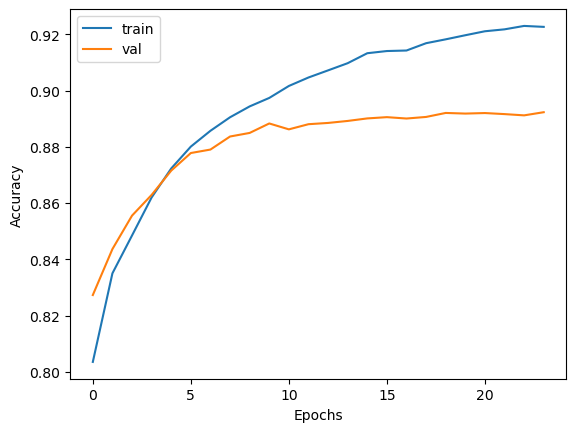

In [10]:
# Step 4: Save the model
pickle.dump(model, open('LSTM.pkl','wb'))

# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


837/837 [==============================] - 58s 69ms/step


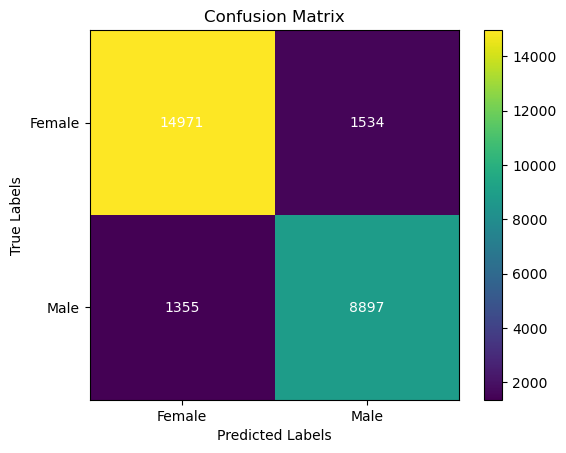

In [22]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import coolwarm
from matplotlib.colors import LinearSegmentedColormap



# load saved model
with open('LSTM.pkl' , 'rb') as f:
    model = pickle.load(f)


# Generate predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Create confusion matrix
confusion = confusion_matrix(y_test, y_pred)

plt.imshow(confusion)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Female', 'Male'])
plt.yticks([0, 1], ['Female', 'Male'])
plt.colorbar()

# Display the values on the plot
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color='white')

plt.show()

In [89]:
def preprocess_name(name):
    name = name.lower()
    name = list(name)
    name_length = 50
    name = (name + [' ']*name_length)[:name_length]
    name = [max(0, ord(char.lower()) - ord('a') + 1) for char in name]
    return name


In [90]:
name = "Alexa"

# Preprocess the name
preprocessed_name = preprocess_name(name)

# Reshape the input to match the expected shape
X_pred = np.reshape(preprocessed_name, (1, -1))

# Make the prediction
prediction = model.predict(X_pred)

# Obtain the gender label and probability
gender_label = "Male" if prediction >= 0.5 else "Female"


# Print the results
print("Name:", name)
print("Gender:", gender_label)



1/1 [==============================] - 0s 406ms/step
Name: Alexa
Gender: Female


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(num_alphabets=27, name_length=50, embedding_dim=128):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


In [15]:

# Step 1: Instantiate the model
CNN = cnn_model(num_alphabets=27, name_length=50, embedding_dim=128)

# Step 2: Split Training and Test Data
X = np.asarray(names_df['Name'].values.tolist())
y = np.asarray(names_df['Gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

CNN.history = CNN.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)



Epoch 1/50
1673/1673 [==============================] - 21s 12ms/step - loss: 0.3988 - accuracy: 0.8242 - val_loss: 0.3584 - val_accuracy: 0.8428
Epoch 2/50
1673/1673 [==============================] - 20s 12ms/step - loss: 0.3515 - accuracy: 0.8489 - val_loss: 0.3403 - val_accuracy: 0.8524
Epoch 3/50
1673/1673 [==============================] - 20s 12ms/step - loss: 0.3319 - accuracy: 0.8567 - val_loss: 0.3259 - val_accuracy: 0.8593
Epoch 4/50
1673/1673 [==============================] - 20s 12ms/step - loss: 0.3194 - accuracy: 0.8633 - val_loss: 0.3238 - val_accuracy: 0.8611
Epoch 5/50
1673/1673 [==============================] - 21s 12ms/step - loss: 0.3074 - accuracy: 0.8692 - val_loss: 0.3150 - val_accuracy: 0.8654
Epoch 6/50
1673/1673 [==============================] - 20s 12ms/step - loss: 0.2989 - accuracy: 0.8735 - val_loss: 0.3084 - val_accuracy: 0.8671
Epoch 7/50
1673/1673 [==============================] - 22s 13ms/step - loss: 0.2917 - accuracy: 0.8766 - val_loss: 0.3117 -

837/837 [==============================] - 3s 4ms/step


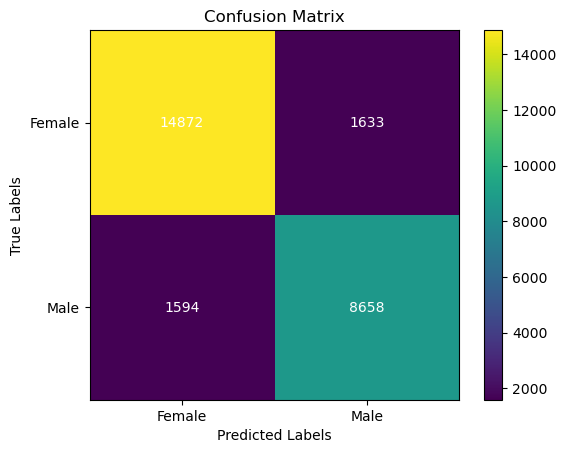

In [23]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import coolwarm
from matplotlib.colors import LinearSegmentedColormap



# load saved model
with open('CNN.pkl' , 'rb') as f:
    model = pickle.load(f)


# Generate predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Create confusion matrix
confusion = confusion_matrix(y_test, y_pred)

plt.imshow(confusion)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Female', 'Male'])
plt.yticks([0, 1], ['Female', 'Male'])
plt.colorbar()

# Display the values on the plot
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color='white')

plt.show()

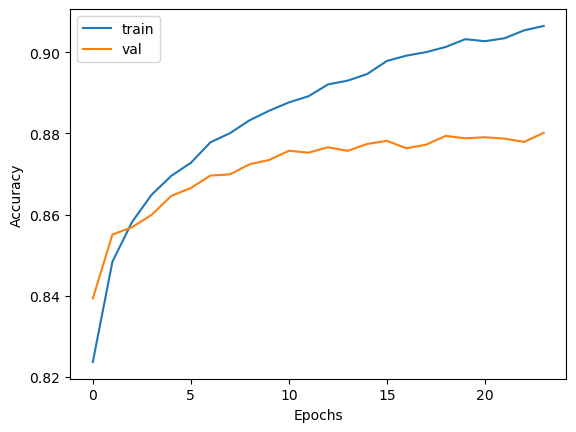

In [12]:
# Step 4: Save the model
pickle.dump(CNN, open('CNN.pkl','wb'))

# Step 5: Plot accuracies
plt.plot(CNN.history.history['accuracy'], label='train')
plt.plot(CNN.history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import svm, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping


kernel = ['linear', 'poly', 'rbf']
degree = [1, 2, 3, 4]
coef0=np.linspace(0, 1, 11)

# Create a classifier: a support vector classifier
grid_search = GridSearchCV(svm.SVC(), cv=5, param_grid={ "kernel": kernel, "degree": degree, "coef0": coef0}, 
                   verbose=1, n_jobs=-1, scoring="accuracy")

# Learn the train subset
print('Fitting ....')
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



Fitting ....
Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best Hyperparameters: {'coef0': 1.0, 'degree': 4, 'kernel': 'poly'}


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import svm, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM model with the best hyperparameters
best_svm_model = svm.SVC(kernel='poly', degree=4, coef0=1.0)


# Implement early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with early stopping
best_svm_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6986209216279852


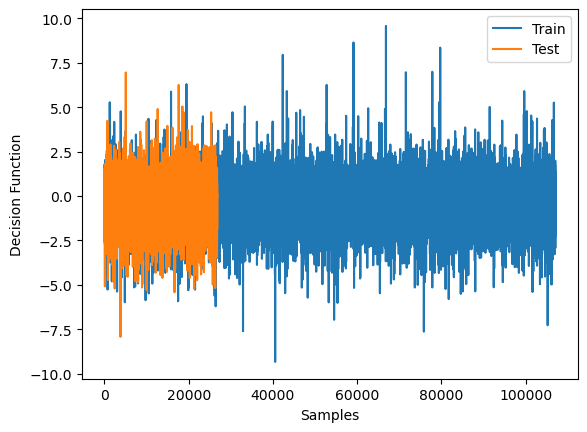

In [29]:
# Plot accuracies
plt.plot(best_svm_model.decision_function(X_train), label='Train')
plt.plot(best_svm_model.decision_function(X_test), label='Test')
plt.xlabel('Samples')
plt.ylabel('Decision Function')
plt.legend()
plt.show()

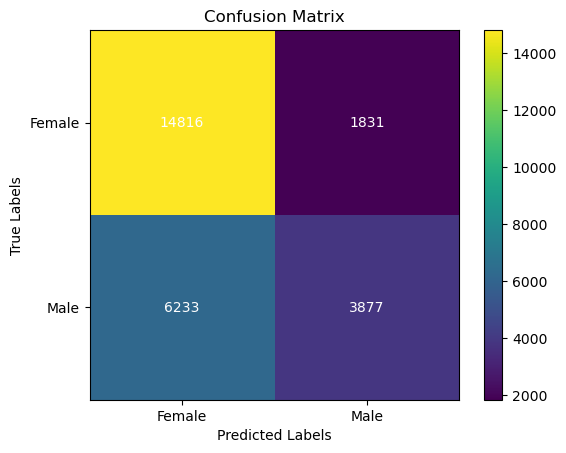

In [28]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import coolwarm
from matplotlib.colors import LinearSegmentedColormap



# Generate predictions
y_pred = best_svm_model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Create confusion matrix
confusion = confusion_matrix(y_test, y_pred)

plt.imshow(confusion)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Female', 'Male'])
plt.yticks([0, 1], ['Female', 'Male'])
plt.colorbar()

# Display the values on the plot
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color='white')

plt.show()